# Домашнее задание №3

В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/

`[X]` - 4 балла: Ваша задача в `sklearn`, используя один из алгоритмов, рассмотренных на паре, построить и обучить классификатор, посчитать метрики качества, построить ROC кривую и посчитайте величину ROC AUC.

`[X]` - 3 балла: Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками).

`[X]` - 3 балла: Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели. 

## Данные

In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def read_imdb(data_dir, is_train):
    data = []
    labels = []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
            
    return data, labels

In [3]:
train_data, y_train = read_imdb('aclImdb', is_train=True)
test_data, y_test = read_imdb('aclImdb', is_train=False)
print('# trainings:', len(train_data))
print('# trainings:', len(test_data))

# trainings: 25000
# trainings: 25000


In [4]:
count_vect = CountVectorizer(stop_words='english',
                             min_df=10,
                             max_features=10000)
X_train = count_vect.fit_transform(train_data)
X_train.shape

(25000, 10000)

In [5]:
X_test = count_vect.transform(test_data)
X_test.shape

(25000, 10000)

## Классификатор

In [6]:
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [7]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



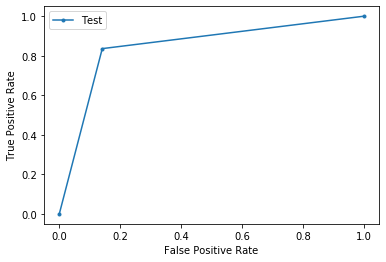

In [9]:
fpr, tpr, thrhld = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.', label='Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [10]:
print(roc_auc_score(y_test, y_pred))

0.84752


## Собстренная реализация метрик

In [11]:
def get_falsetrue_negpos(y_test, y_pred):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for test, pred in zip(y_test, y_pred):
        if test == pred:
            if pred == 0:
                tn += 1
            else:
                tp += 1
        else:
            if pred == 0:
                fn += 1
            else:
                fp += 1
                
    return tp, tn, fp, fn

In [12]:
def print_metrics(y_test, y_pred):
    tp, tn, fp, fn = get_falsetrue_negpos(y_test, y_pred)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    
    print("""metrics for positive class:
precision  recall  f1-score
{:.2f}   {:.2f}   {:.2f}""".format(precision, recall, f1))

In [13]:
print_metrics(y_test, y_pred)

metrics for positive class:
precision  recall  f1-score
0.86   0.84   0.85


## ТОП-15 позитивных и негативных рецензий

In [14]:
import numpy as np

In [15]:
def get_top(test_data, probs, label: int, n=15):
    indexes = np.argsort(probs[:, 1-label])[:n]
    
    return [(i, test_data[i]) for i in indexes]

probs = clf.predict_proba(X_test)

In [16]:
for i, neg in get_top(test_data, probs, 0):
    print(i, neg, end='\n\n==========\n\n')

17909 Snake Island is one of those films that, whilst one sits and watches its amazing level of stupidity, makes one wish the film camera had never been invented. The real reason why Plan 9 From Outer Space will hold onto its honoured title of Worst Film Of All Time for a while to come is not so much because of how bad it is. It is because of the fact that it is the most entertaining bad film you will ever see. Snake Island is the other kind of bad. Snake Island is just so bad that it is excruciating. A stupid premise combines with a script that was written by monkeys tapping one-key typewriters onto transparencies that were then overlapped in order to resemble dialogue to make the most obvious problems here. Filmed entirely on location in South Africa, the environments in which the film takes place are about the only element that can truthfully be considered well-realised. Many shots involving snakes consist of close-ups so surreal in appearance that one begins to wonder whether said 

In [17]:
for i, pos in get_top(test_data, probs, 1):
    print(i, pos, end='\n\n==========\n\n')

1505 It's easy to see why many people consider In the Mood for Love to be Wong Kar-Wai's best film. The toned down appeal of the film, centering on the studied view of a relationship put through an emotional ringer, is a retread into Happy Together territory but without the hyper-kinetic patchwork of jarring film stocks and hyper-saturated sequences that have become a trademark of Kar-Wai's films since Chungking Express. Like Soderbergh's The Limey, this is a different kind of curio for Kar-Wai; where dialogue and plot are forsaken by mood and composition in order to create a tale of two delicate lives in a seemingly confining emotional stasis.<br /><br />It's a testament to the genius of Kar-Wai that he is capable to making such a simple tale so resonating. Chow Mo-Wan (Tony Leung) and Su Li-zhen (Maggie Cheung) move in next-door to each other within the same apartment building. He's a journalist who dreams of publishing martial-arts novels and she is a secretary at a shipping company

_Анна Полянская, БКЛ171_